In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN0-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN4-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN11-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN1-esq.png
/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/137/Segmentadas/PAC_45_DN1-dir.png
/kag

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


2025-05-07 02:46:22.902691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746585983.155057      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746585983.226109      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
def load_dataset():
    # Base directories
    train_dir = "/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"
    
    # Find the DOENTES and SAUDÁVEIS directories
    train_folders = os.listdir(train_dir)
    doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
    saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])
    
    # Function to load images from the "Segmentadas" subdirectories
    def load_images_from_segmentadas(directory, label):
        images = []
        labels = []
        
        for root, dirs, files in os.walk(directory):
            # Only process files inside "Segmentadas" subdirectories
            if "Segmentadas" in root:
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    
                    # Skip non-image files
                    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        continue
                    
                    # Preprocess the image
                    img = preprocess_image(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        
        return images, labels
    
    # Load images from both directories
    print("Loading cancer (DOENTES) images...")
    cancer_images, cancer_labels = load_images_from_segmentadas(doentes_dir, 1)
    
    print("Loading healthy (SAUDÁVEIS) images...")
    healthy_images, healthy_labels = load_images_from_segmentadas(saudaveis_dir, 0)
    
    # Combine datasets
    all_images = cancer_images + healthy_images
    all_labels = cancer_labels + healthy_labels
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    # Print the shape before conversion
    print(f"Dataset shape before RGB conversion: {X.shape}")
    
    # Convert grayscale to RGB (duplicate channels)
    if X.ndim == 3:  # If shape is (n, 224, 224)
        X = np.stack([X, X, X], axis=-1)
    
    # Print the shape after conversion
    print(f"Dataset shape after RGB conversion: {X.shape}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)
    
    return X_train, X_test, y_train, y_test


In [4]:
# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)  # Load in color
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype('float32'))  # Use EfficientNet's preprocessing
    return img

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import AUC

def build_inceptionv3_model(input_shape=(299, 299, 3), num_classes=2):
    # Create the input tensor
    input_tensor = Input(shape=input_shape)
    
    # InceptionV3 model (pre-trained on ImageNet)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Freeze the layers of InceptionV3 (you can unfreeze later for fine-tuning)
    base_model.trainable = False
    
    # Add a custom head to the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Build the full model
    model = Model(inputs=input_tensor, outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=Adamax(),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )
    
    return model


In [6]:
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight


def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Build the model
    model = build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=2)

    # Calculate class weights for imbalanced dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train.flatten()),
        y=y_train.flatten()
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_breast_cancer_model.keras', monitor='val_accuracy',
                                       save_best_only=True, mode='max')

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, model_checkpoint]
    )

    model.save('my_model.h5')

      # Evaluate the model
    eval_results = model.evaluate(X_test, y_test)
    for metric_name, metric_value in zip(model.metrics_names, eval_results):
        print(f"{metric_name}: {metric_value:.4f}")

    # Extract and print test accuracy
    if 'accuracy' in model.metrics_names:
        test_accuracy_index = model.metrics_names.index('accuracy')
        test_accuracy = eval_results[test_accuracy_index]
        print(f"Test Accuracy: {test_accuracy:.4f}")

    # Print training and validation performance
    train_accuracy = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # AUC Score
    auc = roc_auc_score(y_test_labels, y_pred[:, 1])
    print(f"AUC Score: {auc:.4f}")

    # Cohen's Kappa Score
    kappa = cohen_kappa_score(y_test_labels, y_pred_labels)
    print(f"Cohen's Kappa Score: {kappa:.4f}")

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    print(cm)

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_labels, y_pred[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.show()

    return model


In [7]:
# Load and preprocess dataset
print("Loading and preprocessing the dataset...")
X_train, X_test, y_train, y_test = load_dataset() 

Loading and preprocessing the dataset...
Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224, 3)
Dataset shape after RGB conversion: (1282, 224, 224, 3)


Training the model...


2025-05-07 02:46:48.194231: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5968 - auc: 0.6039 - loss: 19.3746 - val_accuracy: 0.7665 - val_auc: 0.7707 - val_loss: 5.4852
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6549 - auc: 0.6740 - loss: 11.2128 - val_accuracy: 0.7938 - val_auc: 0.8098 - val_loss: 4.0375
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7312 - auc: 0.7436 - loss: 7.8062 - val_accuracy: 0.8210 - val_auc: 0.8426 - val_loss: 3.1223
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7169 - auc: 0.7420 - loss: 8.2228 - val_accuracy: 0.8521 - val_auc: 0.8767 - val_loss: 1.7190
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7996 - auc: 0.8140 - loss: 4.9365 - val_accuracy: 0.8988 - val_auc: 0.9271 - val_loss: 1.0881
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7618 - auc: 0.7834 - loss: 5.5971 - val_accuracy: 0.9144 - val_auc: 0.9400 - val_loss: 0.9617

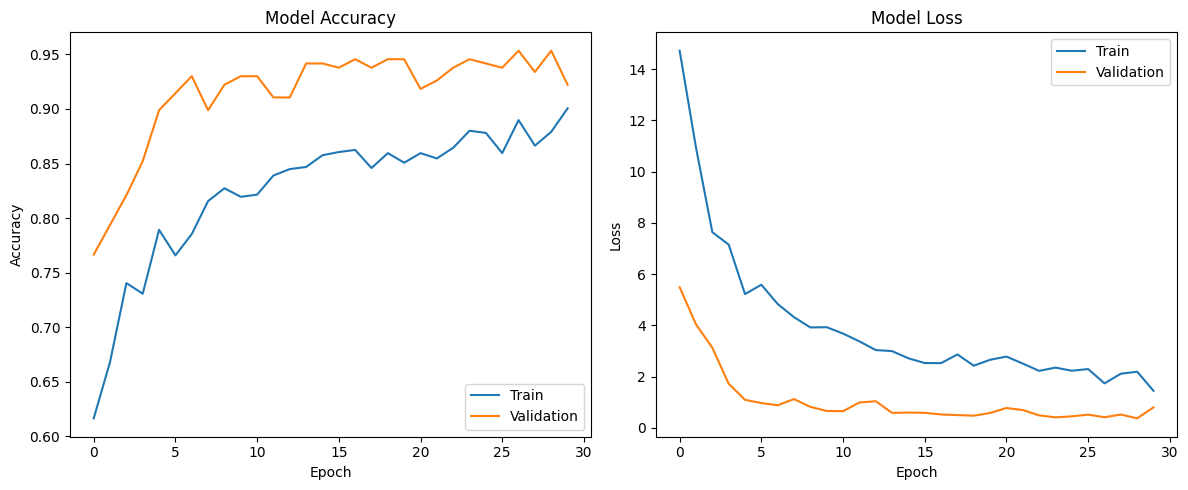

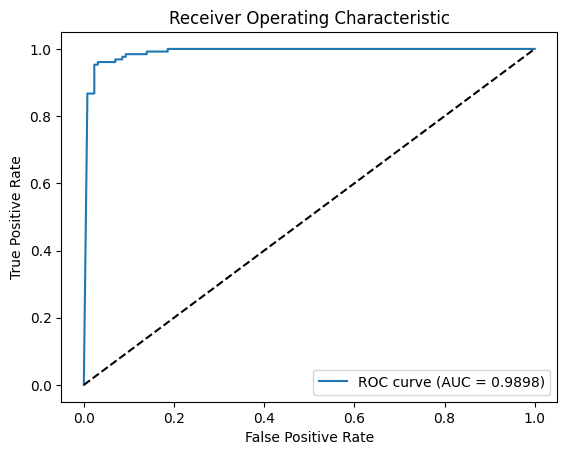

Training and evaluation completed.


In [8]:
 # Train and evaluate the model
print("Training the model...")
model = train_and_evaluate(X_train, X_test, y_train, y_test)
    
print("Training and evaluation completed.")


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, classification_report, confusion_matrix

# === Step 1: Load saved model ===
model = load_model('my_model.h5')

# === Step 2: Load your test data ===
# Replace this with actual loading logic as needed
# Example (assuming you saved these earlier):
# X_test = np.load('X_test.npy')
# y_test = np.load('y_test.npy')

# For this example, we simulate test data (delete this part in real use):
# -------------------------------------------------------------
# Simulated placeholder data - remove these lines in real use
X_test = np.random.rand(100, 224, 224, 3)
y_test = np.random.randint(0, 2, 100)
# -------------------------------------------------------------

# === Step 3: Preprocess labels ===
y_test_cat = to_categorical(y_test, num_classes=2)

# === Step 4: Predict using the model ===
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# === Step 5: Evaluation metrics ===
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob[:, 1])
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Test Accuracy (sklearn): {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
